#### load libraries 

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "data" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data\dot_traffic_stations_2015.txt
data\dot_traffic_US.txt


In [7]:
# !pip install pydot
# !pip install graphviz

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from scipy import stats
import numpy as np
import pandas as pd
import pydot
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from graphviz import Source
from sklearn import tree

# display warnings only the first time
import warnings
warnings.filterwarnings('ignore')

In [24]:
### SPARK LIBRARIES
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('Dataframe').getOrCreate()
spark

In [25]:
## read the dataset
# df_pyspark=spark.read.option('header','true').csv('data/dot_traffic_stations_2015.txt',inferSchema=True)

In [26]:
### Check the schema
# df_pyspark.printSchema()

root
 |-- algorithm_of_vehicle_classification: string (nullable = true)
 |-- algorithm_of_vehicle_classification_name: string (nullable = true)
 |-- calibration_of_weighing_system: string (nullable = true)
 |-- calibration_of_weighing_system_name: string (nullable = true)
 |-- classification_system_for_vehicle_classification: integer (nullable = true)
 |-- concurrent_route_signing: integer (nullable = true)
 |-- concurrent_signed_route_number: string (nullable = true)
 |-- direction_of_travel: integer (nullable = true)
 |-- direction_of_travel_name: string (nullable = true)
 |-- fips_county_code: integer (nullable = true)
 |-- fips_state_code: integer (nullable = true)
 |-- functional_classification: string (nullable = true)
 |-- functional_classification_name: string (nullable = true)
 |-- hpms_sample_identifier: string (nullable = true)
 |-- hpms_sample_type: string (nullable = true)
 |-- lane_of_travel: integer (nullable = true)
 |-- lane_of_travel_name: string (nullable = true)
 |-

In [27]:
# traffic_station_df = df_pyspark.toPandas()

Importing both the datasets

In [6]:
# traffic station characteristics

# # change the path name of the dataset according to the location of data on your device.
traffic_station_df = pd.read_csv("data/dot_traffic_stations_2015.txt",
                                 header=0, sep=',', quotechar='"')

# # traffic volume metrics associated to each traffic station

# # change the path name of the dataset according to the location of data on your device.
traffic_df = pd.read_csv("data/dot_traffic_US.txt",
                         header=0, sep=',', quotechar='"')

# rename long feature names
traffic_station_df.rename(columns = {"number_of_lanes_in_direction_indicated": "lane_count"}, inplace = True)

# **CLEANING DATA - TRAFFIC DATA**

In [7]:
print('Traffic data:')
traffic_df.head()

Traffic data:


,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,...,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,...,89,122,124,110,69,73,28,12,6,15
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,...,1617,1669,1308,1068,928,885,798,650,613,15
2,2015-06-16,16,3,3,East,6,1U,Urban: Principal Arterial - Interstate,0,6,...,4244,4405,4609,4361,3272,2243,2050,1453,892,15
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,...,1011,959,851,708,559,457,297,207,110,15
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,...,83,61,55,35,29,21,23,9,7,15


In [11]:
print("Total Number of Rows & Columns :: ")
print(traffic_df.shape)

Total Number of Rows & Columns :: 
(7140391, 38)


We can see here that '**restrictions**' column is completely **empty** and therefore will be of no use to us.

In [12]:
traffic_df.isnull().sum()

date                                               0
day_of_data                                        0
day_of_week                                        0
direction_of_travel                                0
direction_of_travel_name                           0
fips_state_code                                    0
functional_classification                          0
functional_classification_name                     0
lane_of_travel                                     0
month_of_data                                      0
record_type                                        0
restrictions                                 7140391
station_id                                         0
traffic_volume_counted_after_0000_to_0100          0
traffic_volume_counted_after_0100_to_0200          0
traffic_volume_counted_after_0200_to_0300          0
traffic_volume_counted_after_0300_to_0400          0
traffic_volume_counted_after_0400_to_0500          0
traffic_volume_counted_after_0500_to_0600     

dropping **restrictions** column because it contains all values as null

In [13]:
# dropping restrictions column because it contains all values as null
traffic_df.dropna(how='all', axis=1, inplace=True)
traffic_df.reset_index(inplace=True, drop=True)

In [14]:
traffic_df.dtypes

date                                         object
day_of_data                                   int64
day_of_week                                   int64
direction_of_travel                           int64
direction_of_travel_name                     object
fips_state_code                               int64
functional_classification                    object
functional_classification_name               object
lane_of_travel                                int64
month_of_data                                 int64
record_type                                   int64
station_id                                   object
traffic_volume_counted_after_0000_to_0100     int64
traffic_volume_counted_after_0100_to_0200     int64
traffic_volume_counted_after_0200_to_0300     int64
traffic_volume_counted_after_0300_to_0400     int64
traffic_volume_counted_after_0400_to_0500     int64
traffic_volume_counted_after_0500_to_0600     int64
traffic_volume_counted_after_0600_to_0700     int64
traffic_volu

Changing the datatype of date column to datetime as the given datatype is not correct.

In [15]:
# Changing the datatype of date column to datetime as the given datatype is not correct.
traffic_df['date']= pd.to_datetime(traffic_df['date'], format='%Y-%m-%d')

# **CLEANING DATA - STATION DATA**

In [16]:
# view top of station dataframe
print('Traffic Station data:')
traffic_station_df.head()

Traffic Station data:


,algorithm_of_vehicle_classification,algorithm_of_vehicle_classification_name,calibration_of_weighing_system,calibration_of_weighing_system_name,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,direction_of_travel,direction_of_travel_name,fips_county_code,...,sample_type_for_vehicle_classification_name,second_type_of_sensor,shrp_site_identification,station_id,station_location,type_of_sensor,type_of_sensor_name,year_of_data,year_station_discontinued,year_station_established
0,NaN,NaN,NaN,NaN,13,3,091,7,West,59,...,Station not used for Heavy Vehicle Travel Info...,N,NaN,129130,LAKEVIEW AVENUE ORA91R10.091,L,Inductance loop,15,0,97
1,NaN,NaN,NaN,NaN,13,3,099,5,South,77,...,Station not used for Heavy Vehicle Travel Info...,N,NaN,100190,LITTLE JOHN CREEK SJ9912.526,L,Inductance loop,15,0,97
2,G,Axle spacing with Scheme F modified,NaN,NaN,15,1,005,1,North,93,...,Station used for Heavy Vehicle Travel Informat...,N,NaN,022940,EDGEWOOD SIS5R22.999,P,Piezoelectric,15,0,69
3,D,Vehicle length classification,M,Moving average of the steering axle of 3S2s,13,0,NaN,5,South,35,...,Station not used for Heavy Vehicle Travel Info...,NaN,NaN,000302,I 15 12900 South M.P. 290.6,X,Radio wave,15,0,11
4,G,Axle spacing with Scheme F modified,0,NaN,14,1,000000,7,West,27,...,Station not used for Heavy Vehicle Travel Info...,NaN,NaN,W01136,E. of Franklin Rd Underpass,L,Inductance loop,15,0,95


Here we are trying to observe the dataset so that we can clean it more efficiently

In [11]:
# we are dropping the columns with more than 60% NULL values as they will not be able to contribute in the dataset and will reduce the model accuracy
traffic_station_df.drop(['concurrent_signed_route_number', 'hpms_sample_identifier', 
                         'lrs_identification', 'lrs_location_point', 
                         'shrp_site_identification'], axis = 1, inplace=True)

# here we are only dropping the rows which contains the null values in 'latitude', 'longitude', 'station_location' because they contain 
# significatly less null values and are useful columns.
traffic_station_df.dropna(subset=['latitude', 'longitude', 'station_location'], inplace=True)
traffic_station_df.reset_index(inplace=True, drop=True)

In [17]:
print('Traffic_Station_Null_Mean: \n')
print(traffic_station_df.isnull().mean(), end = '\n\n')

print('Traffic_Station_Shape: \n')
print(traffic_station_df.shape, end = '\n\n')

Traffic_Station_Null_Mean: 

algorithm_of_vehicle_classification                 0.347432
algorithm_of_vehicle_classification_name            0.391028
calibration_of_weighing_system                      0.713167
calibration_of_weighing_system_name                 0.765299
classification_system_for_vehicle_classification    0.000000
concurrent_route_signing                            0.000000
concurrent_signed_route_number                      0.522518
direction_of_travel                                 0.000000
direction_of_travel_name                            0.000000
fips_county_code                                    0.000000
fips_state_code                                     0.000000
functional_classification                           0.000000
functional_classification_name                      0.000000
hpms_sample_identifier                              0.535657
hpms_sample_type                                    0.000000
lane_of_travel                                      0.00

# **EDA - TRAFFIC DATA**    (Feature Engineering)


In [18]:
variables = ['traffic_volume_counted_after_0000_to_0100', 'traffic_volume_counted_after_0100_to_0200', 'traffic_volume_counted_after_0200_to_0300',
            'traffic_volume_counted_after_0300_to_0400', 'traffic_volume_counted_after_0400_to_0500', 'traffic_volume_counted_after_0500_to_0600',
             'traffic_volume_counted_after_0600_to_0700', 'traffic_volume_counted_after_0700_to_0800', 'traffic_volume_counted_after_0800_to_0900',
             'traffic_volume_counted_after_0900_to_1000', 'traffic_volume_counted_after_1000_to_1100', 'traffic_volume_counted_after_1100_to_1200',
             'traffic_volume_counted_after_1200_to_1300', 'traffic_volume_counted_after_1300_to_1400', 'traffic_volume_counted_after_1400_to_1500',
             'traffic_volume_counted_after_1500_to_1600', 'traffic_volume_counted_after_1600_to_1700', 'traffic_volume_counted_after_1700_to_1800',
             'traffic_volume_counted_after_1800_to_1900', 'traffic_volume_counted_after_1900_to_2000', 'traffic_volume_counted_after_2000_to_2100',
             'traffic_volume_counted_after_2100_to_2200', 'traffic_volume_counted_after_2200_to_2300', 'traffic_volume_counted_after_2300_to_2400']

# we will be starting by correcting the datatype of all the time-slots that are given to us, so that we will be able to sum them up very easily.
traffic_df[variables] = traffic_df[variables].astype(float).astype(int)

Here we are merging the time-slots in the **bucket of 4 hours** so that instead of dealing with 24 hours we will only have to deal with more accurate and less data.

In [19]:
till_4 = ['traffic_volume_counted_after_0000_to_0100', 'traffic_volume_counted_after_0100_to_0200', 'traffic_volume_counted_after_0200_to_0300',
         'traffic_volume_counted_after_0300_to_0400']
till_8 = ['traffic_volume_counted_after_0400_to_0500', 'traffic_volume_counted_after_0500_to_0600','traffic_volume_counted_after_0600_to_0700',
         'traffic_volume_counted_after_0700_to_0800']
till_12 = ['traffic_volume_counted_after_0800_to_0900','traffic_volume_counted_after_0900_to_1000', 'traffic_volume_counted_after_1000_to_1100',
          'traffic_volume_counted_after_1100_to_1200']
till_16 = ['traffic_volume_counted_after_1200_to_1300', 'traffic_volume_counted_after_1300_to_1400', 'traffic_volume_counted_after_1400_to_1500',
            'traffic_volume_counted_after_1500_to_1600']
till_20 = ['traffic_volume_counted_after_1600_to_1700', 'traffic_volume_counted_after_1700_to_1800','traffic_volume_counted_after_1800_to_1900',
           'traffic_volume_counted_after_1900_to_2000']
till_24 = ['traffic_volume_counted_after_2000_to_2100','traffic_volume_counted_after_2100_to_2200', 'traffic_volume_counted_after_2200_to_2300',
           'traffic_volume_counted_after_2300_to_2400']

# Here we are summing up the data of 4 hours and creating the new column with the new data that we have got after summing up.
traffic_df['1_to_4'] = traffic_df[till_4].sum(axis=1, numeric_only= True)
traffic_df['5_to_8'] = traffic_df[till_8].sum(axis=1, numeric_only= True)
traffic_df['9_to_12'] = traffic_df[till_12].sum(axis=1, numeric_only= True)
traffic_df['13_to_16'] = traffic_df[till_16].sum(axis=1, numeric_only= True)
traffic_df['17_to_20'] = traffic_df[till_20].sum(axis=1, numeric_only= True)
traffic_df['21_to_24'] = traffic_df[till_24].sum(axis=1, numeric_only= True)

# here we are dropping the columns named 'year_of_data', 'record_type' because they have only one value throughout the data which will affect our model accuracy.
traffic_df.drop(variables, axis = 1, inplace=True)
traffic_df.drop(['year_of_data', 'record_type'], axis = 1, inplace=True)
traffic_df.head()

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,station_id,1_to_4,5_to_8,9_to_12,13_to_16,17_to_20,21_to_24
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,000084,13,381,581,523,425,119
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,056P94,1045,1700,4325,5829,4973,2946
2,2015-06-16,16,3,3,East,6,1U,Urban: Principal Arterial - Interstate,0,6,077590,1685,12487,18061,16324,16647,6638
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,450001,312,811,3021,4057,3077,1071
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,102210,15,80,310,356,180,60


After creating bucket of 4 hours, here i am dividing the value of every **bucket by 4** so that out values does not explode and we only get the data of each hour relatively.

In [20]:
traffic_df['1_to_4'] = traffic_df['1_to_4'].div(4)
traffic_df['5_to_8'] = traffic_df['5_to_8'].div(4)
traffic_df['9_to_12'] = traffic_df['9_to_12'].div(4)
traffic_df['13_to_16'] = traffic_df['13_to_16'].div(4)
traffic_df['17_to_20'] = traffic_df['17_to_20'].div(4)
traffic_df['21_to_24'] = traffic_df['21_to_24'].div(4)
traffic_df.head()

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,station_id,1_to_4,5_to_8,9_to_12,13_to_16,17_to_20,21_to_24
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,000084,3.25,95.25,145.25,130.75,106.25,29.75
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,056P94,261.25,425.00,1081.25,1457.25,1243.25,736.50
2,2015-06-16,16,3,3,East,6,1U,Urban: Principal Arterial - Interstate,0,6,077590,421.25,3121.75,4515.25,4081.00,4161.75,1659.50
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,450001,78.00,202.75,755.25,1014.25,769.25,267.75
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,102210,3.75,20.00,77.50,89.00,45.00,15.00


From the below **boxplot**'s we can clearly see that there exists some **outliers in the dataset**. Therefore now we will be working on removing the outliers present in the data. 

> 1.   In statistics, an outlier is an observation point that is distant from other observations.
> 2.   In descriptive statistics, a box plot is a method for graphically depicting groups of numerical data through their quartiles. Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. Outliers may be plotted as individual points.

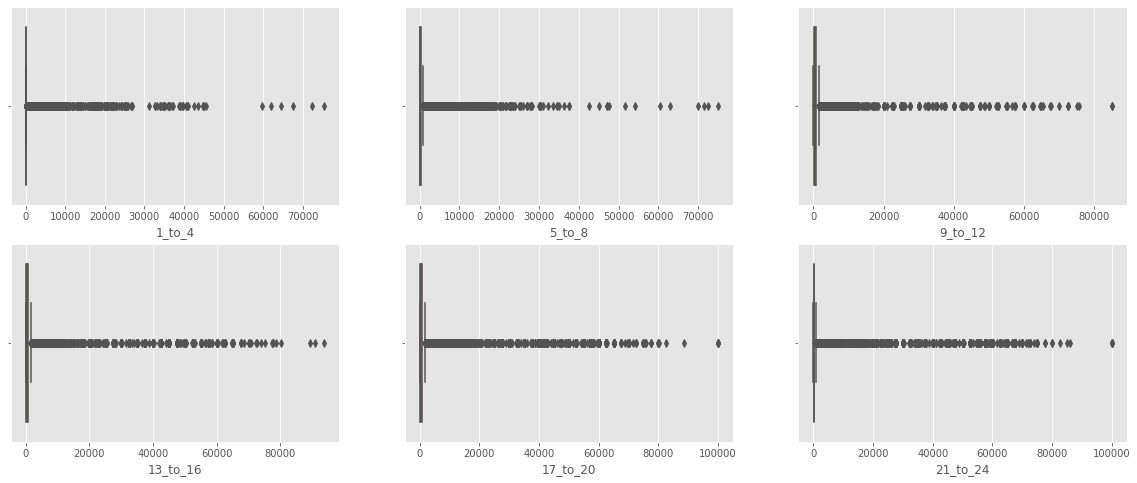

In [21]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
plt.figure(figsize = (20,8))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    sns.boxplot(x=traffic_df[timings[i-1]])

For more detailed look we can see that **between hour 1 and 4** there exists many **outliers** and most of them are **above 3000 range**.

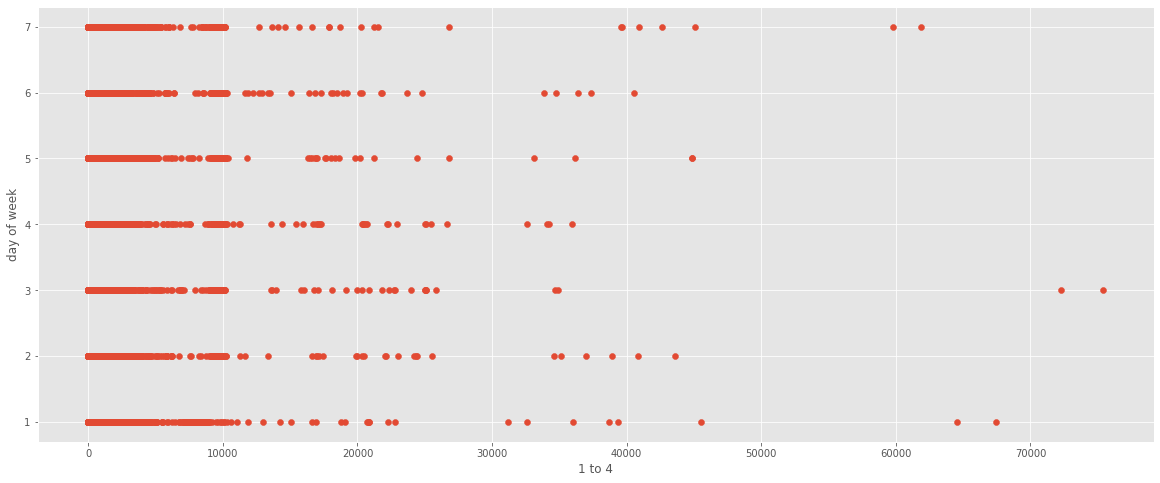

In [17]:
# For more detailed look we can see that between hour 1 and 4 there exists many outliers and most of them are above 3000 range.

fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(traffic_df['1_to_4'], traffic_df['day_of_week'])
ax.set_xlabel('1 to 4')
ax.set_ylabel('day of week')
plt.show()

Here we have used **Z-Score** to detect all the outliers present in the dataset.

The intuition behind Z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points. Z-score is finding the distribution of data where mean is 0 and standard deviation is 1 i.e. normal distribution.

**how does this help in identifying the outliers?**

> While calculating the Z-score we re-scale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used i.e if the Z-score value is greater than or less than 3 or -3 respectively, that data point will be identified as outliers.

We will use Z-score function defined in scipy library to detect the outliers.

1.   The **Z-score** is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.


In [18]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
z = np.abs(stats.zscore(traffic_df[timings]))
print(z)
threshold = 3
print(np.where(z > 3))

           1_to_4    5_to_8   9_to_12  13_to_16  17_to_20  21_to_24
0        0.358161  0.383019  0.490278  0.539823  0.529487  0.369380
1        0.808870  0.122992  0.555000  0.738117  0.562474  0.642094
2        1.532610  4.261234  4.389921  3.265818  3.365364  1.963056
3        0.020038  0.218057  0.190940  0.311335  0.107250  0.028763
4        0.355899  0.498493  0.565938  0.580044  0.588310  0.390490
...           ...       ...       ...       ...       ...       ...
7140386  0.354768  0.514221  0.598324  0.600275  0.584469  0.396930
7140387  0.319712  0.088390  0.166421  0.015496  0.049627  0.237713
7140388  0.093046  0.259565  0.080940  0.021036  0.149894  0.111055
7140389  2.074285  7.203694  6.020935  5.271119  4.729114  2.944833
7140390  0.334413  0.414477  0.514009  0.539823  0.460339  0.340041

[7140391 rows x 6 columns]
(array([      2,       2,       2, ..., 7140389, 7140389, 7140389]), array([1, 2, 3, ..., 2, 3, 4]))


In the below cell we are taking only the values which are between the range of **-3 to 3 in Z-Score**.

All other values are outliers.

In [19]:
traffic_df[timings] = traffic_df[timings][(z < 3).all(axis=1)]
traffic_df[timings] = traffic_df[timings][(-3 < z).all(axis=1)]
traffic_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

Now when we are running the boxplot again we can clearly see that all the outliers that were present in the dataset have been removed.

Hence we have now obtained a consistent and good performing dataset.

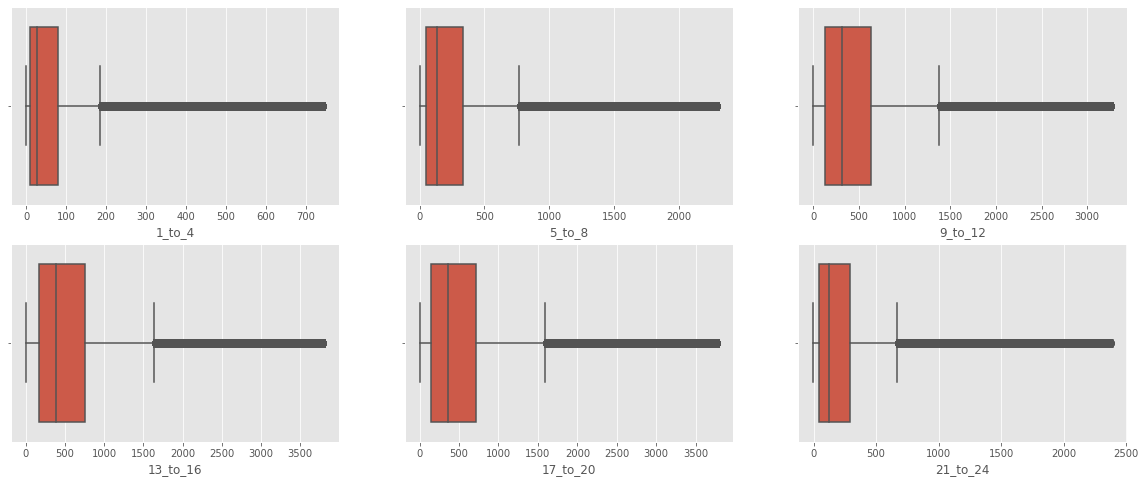

In [20]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
plt.figure(figsize = (20,8))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    sns.boxplot(x=traffic_df[timings[i-1]])

We can also see from the below cell output that the** data consistency have been improved in all the time bucket sections** where we have appied the **Z-Score method** and there is nearly no visible difference between the **mean, 75%, and maximum** value of the dataset.

In [21]:
traffic_df.describe()

,day_of_data,day_of_week,direction_of_travel,fips_state_code,lane_of_travel,month_of_data,1_to_4,5_to_8,9_to_12,13_to_16,17_to_20,21_to_24
count,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06
mean,1.572624e+01,4.012449e+00,3.885063e+00,2.985262e+01,1.335427e+00,6.518998e+00,6.073193e+01,2.552298e+02,4.552350e+02,5.455916e+02,5.171385e+02,2.138846e+02
std,8.770013e+00,2.000232e+00,2.281844e+00,1.657622e+01,1.071629e+00,3.456660e+00,8.323963e+01,3.154451e+02,4.602179e+02,5.339154e+02,5.242792e+02,2.468112e+02
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,8.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,4.000000e+00,9.000000e+00,4.700000e+01,1.282500e+02,1.640000e+02,1.435000e+02,4.500000e+01
50%,1.600000e+01,4.000000e+00,5.000000e+00,3.000000e+01,1.000000e+00,7.000000e+00,2.700000e+01,1.355000e+02,3.105000e+02,3.905000e+02,3.545000e+02,1.267500e+02
75%,2.300000e+01,6.000000e+00,5.000000e+00,4.400000e+01,2.000000e+00,1.000000e+01,7.975000e+01,3.357500e+02,6.277500e+02,7.545000e+02,7.207500e+02,2.940000e+02
max,3.100000e+01,7.000000e+00,9.000000e+00,5.600000e+01,9.000000e+00,1.200000e+01,7.455000e+02,2.299750e+03,3.270500e+03,3.805000e+03,3.781250e+03,2.383750e+03


## **Pattern 1**

On the basis of below bar plot between **Traffic count and Days of weeks** across all time frames we can conclude that:

- The **maximum amout of Traffic occurs on Day 6 i.e saturday around the hours of 12 to 16 i.e. Afternoon Hours**.
- Also the traffic on other days is almost similar and the **minimum amount of traffic occurs during eary morning hours between 1 to 4**.

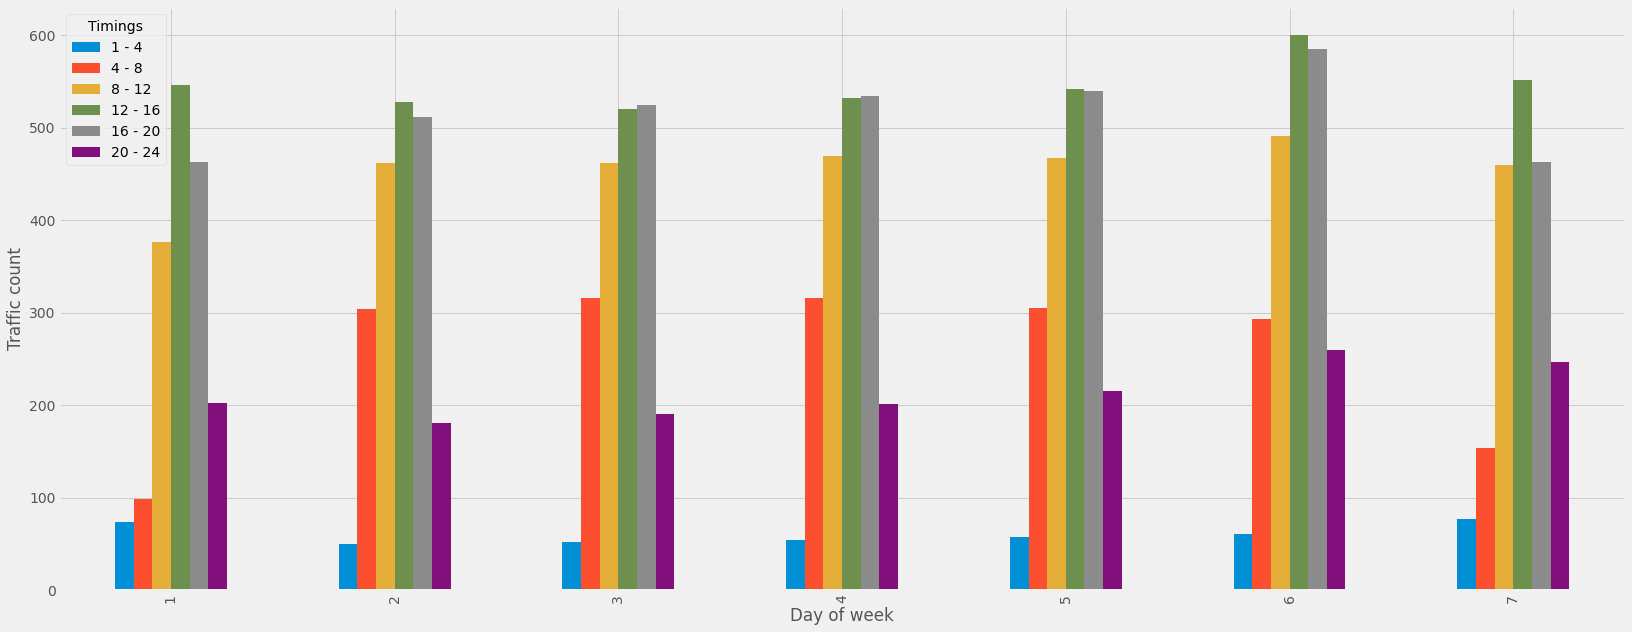

In [22]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
Week_Traffic = pd.DataFrame(traffic_df.groupby(['day_of_week'], axis=0, as_index=False)[timings].mean())

legends=['1 - 4','4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24']
plt.style.use('fivethirtyeight')

Week_Traffic.plot(x='day_of_week', y=timings, kind="bar", figsize=(25,10), xlabel = 'Day of week', ylabel = 'Traffic count')
plt.legend(title='Timings', labels=legends)

In [23]:
# We are renaming the very long direction name in this code cell

traffic_df["direction_of_travel_name"].replace({"North-South or Northeast-Southwest combined (ATR stations only)": "Northeast-Southwest", 
                                                "East-West or Southeast-Northwest combined (ATR stations only)": "Southeast-Northwest"}, inplace=True)

The below code cell helps us to observe the data more vividly and understand it better.

In [24]:
print('functional classification:'.upper())
print(dict(traffic_df['functional_classification'].value_counts()), end = '\n\n')

print('functional classification name:'.upper())
print(dict(traffic_df['functional_classification_name'].value_counts()), end = '\n\n')


print('fips state code:'.upper())
print(dict(traffic_df['fips_state_code'].value_counts()), end = '\n\n')


print('direction of travel:'.upper())
print(dict(traffic_df['direction_of_travel'].value_counts()), end = '\n\n')


print('direction of travel name:'.upper())
print(dict(traffic_df['direction_of_travel_name'].value_counts()), end = '\n\n')

FUNCTIONAL CLASSIFICATION:
{'1U': 1548157, '3R': 1392830, '3U': 1108945, '1R': 992054, '2U': 604921, '4R': 485936, '5R': 319145, '4U': 314540, '5U': 79926, '6R': 37096, '7U': 10688, '7R': 7716}

FUNCTIONAL CLASSIFICATION NAME:
{'Urban: Principal Arterial - Interstate': 1548157, 'Rural: Principal Arterial - Other': 1392830, 'Urban: Principal Arterial - Other': 1108945, 'Rural: Principal Arterial - Interstate': 992054, 'Urban: Principal Arterial - Other Freeways or Expressways': 604921, 'Rural: Minor Arterial': 485936, 'Rural: Major Collector': 319145, 'Urban: Minor Arterial': 314540, 'Urban: Collector': 79926, 'Rural: Minor Collector': 37096, 'Urban: Local System': 10688, 'Rural: Local System': 7716}

FIPS STATE CODE:
{12: 606214, 39: 455679, 51: 451780, 13: 355635, 55: 298451, 53: 266437, 16: 252638, 36: 245816, 40: 202741, 28: 194818, 29: 191551, 1: 183643, 49: 168084, 32: 158457, 15: 151351, 56: 147386, 26: 145656, 19: 144872, 6: 143013, 48: 142145, 30: 126627, 35: 119045, 10: 111765

In The below code cell i have created a function so that i can create a dictionary for the appropriate Feature to match with its Feature name.

Example: Direction and Direction name can be matched, Functional Classification and Functional Classification name can be matched together.

In [25]:
def columnWithName(dict1, dict2):
    ans = {}
    for k, v in dict1.items():
        for k1, v1 in dict2.items():
            if v == v1:
                ans[k] = k1
    return ans

In the below code cell i am making use of the above created function to match the Features with its namings.

In [26]:
functional_classification1 = dict(traffic_df['functional_classification'].value_counts())
functional_classification_name1 = dict(traffic_df['functional_classification_name'].value_counts())
functional_classification_dict = columnWithName(functional_classification1, functional_classification_name1)


direction_of_travel1 = dict(traffic_df['direction_of_travel'].value_counts())
direction_of_travel_name1 = dict(traffic_df['direction_of_travel_name'].value_counts())
direction_of_travel_dict = columnWithName(direction_of_travel1, direction_of_travel_name1)

## **Pattern 2**

In the below Bar plot we have created the Graph between **Direction of travel and The traffic count** on Diferrent days across all time Frames.

1. With this we can Easily conclude that **Northeast-Southwest Direction have the maximum amount of traffic specially on Hours 1 to 4, 4 to 8 i.e. early mornings and at Late nights between hours 20 to 24**.

2. We can also conclude that **The traffic on time range 8 to 12 is extremely less irrespective of Direction of travel**.

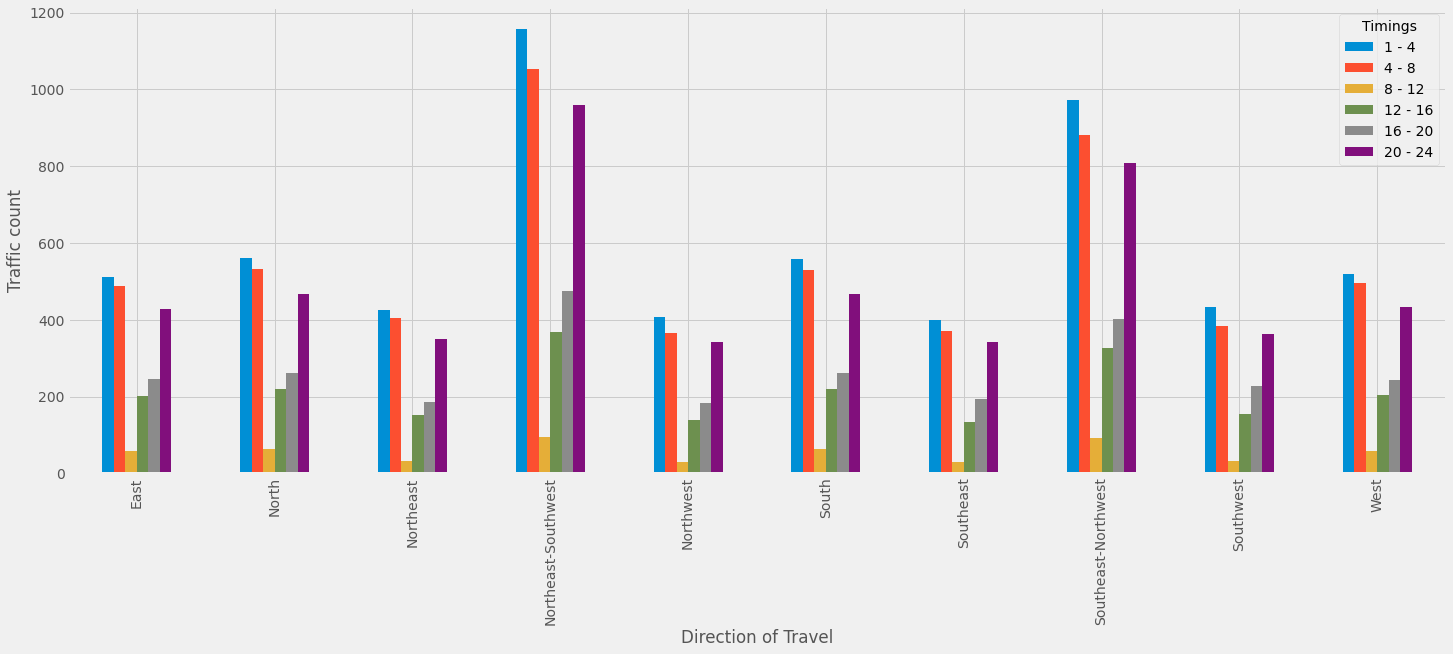

In [27]:
legends=['1 - 4','4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24']
direction_EDA = pd.pivot_table(data=traffic_df, index=['direction_of_travel_name'], values=timings)
direction_EDA.plot(kind='bar', figsize=(22,8), xlabel = 'Direction of Travel', ylabel = 'Traffic count')
plt.style.use('fivethirtyeight')
plt.legend(title='Timings', labels=legends)

We can also conclude on the basis of the below density graph that **highest density of traffic is in Direction number 1 and 5 i.e. North and South across all the times included.**

**More Proof for Pattern 2**

<AxesSubplot:xlabel='direction_of_travel', ylabel='Density'>

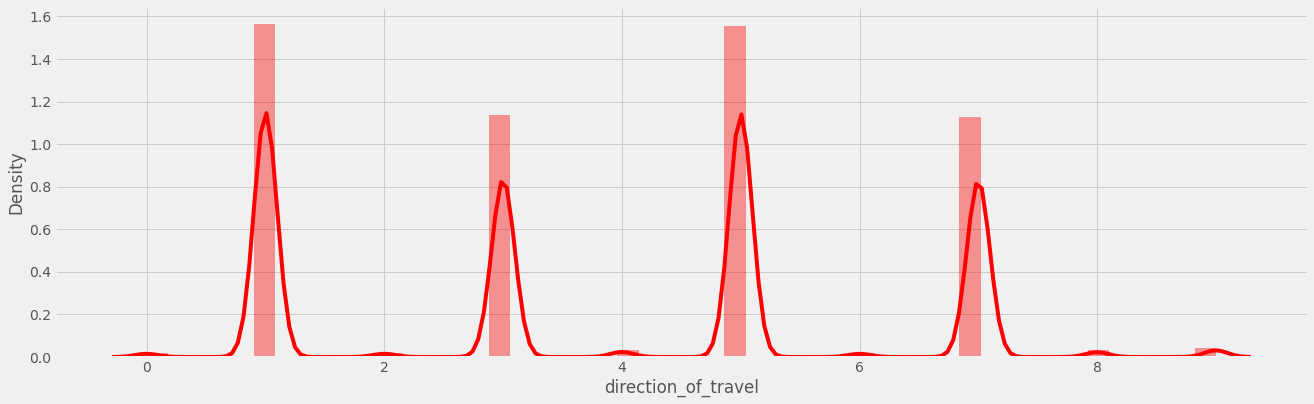

In [28]:
plt.figure(figsize=(20,6))
plt.figure(1)

sns.distplot(traffic_df['direction_of_travel'],color='red')

## **Pattern 3**

In the below Graph we have created the Graph between **Lane of travel and The traffic count** on Diferrent days **across all time frames**.

1. With this we can Easily conclude that **Lane number 8 have the maximum amount of traffic specially on Hours 1 to 4 and 4 to 8 i.e Early Mornings**, and the **Least amount of traffic on Lane number 1**.

2. We can also observe that on the **time range of 8 to 12 the traffic is very least irrespective of Lane number**.



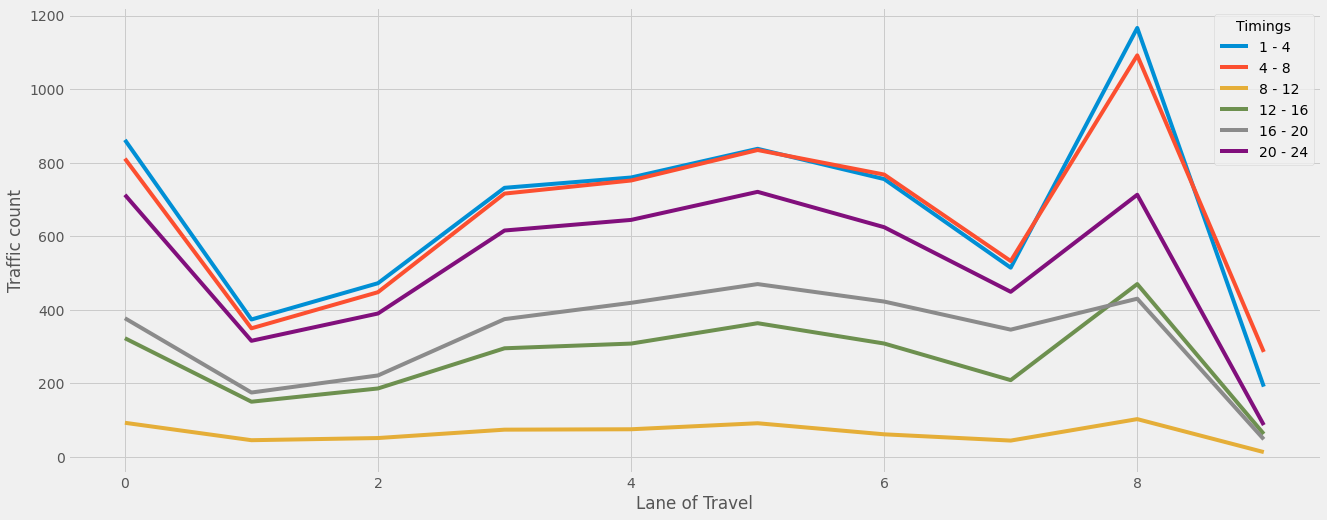

In [29]:
legends=['1 - 4','4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24']
direction_EDA = pd.pivot_table(data=traffic_df, index=['lane_of_travel'], values=timings)
direction_EDA.plot(kind='line', figsize=(20,8), xlabel = 'Lane of Travel', ylabel = 'Traffic count')
plt.style.use('fivethirtyeight')
plt.legend(title='Timings', labels=legends)

## **Pattern 4**

In the below Graph we have created the Graph between **Functional Classification and The traffic count** on Diferrent days **across all time frames**.

1. With this we can Easily conclude that **Urban Principal Arterial: Interstate and Other Expressways have the maximum amount of traffic specially on Hours 1 to 4 and 4 to 8 i.e Early Mornings and Late night between hours 20 to 24**, also the **Least amount of traffic on Lane number 1**.

2. We can also observe that on the **time range of 8 to 12 the traffic is very least irrespective of Functional Classification** and on the **Rural Local system we have the least Traffic**.

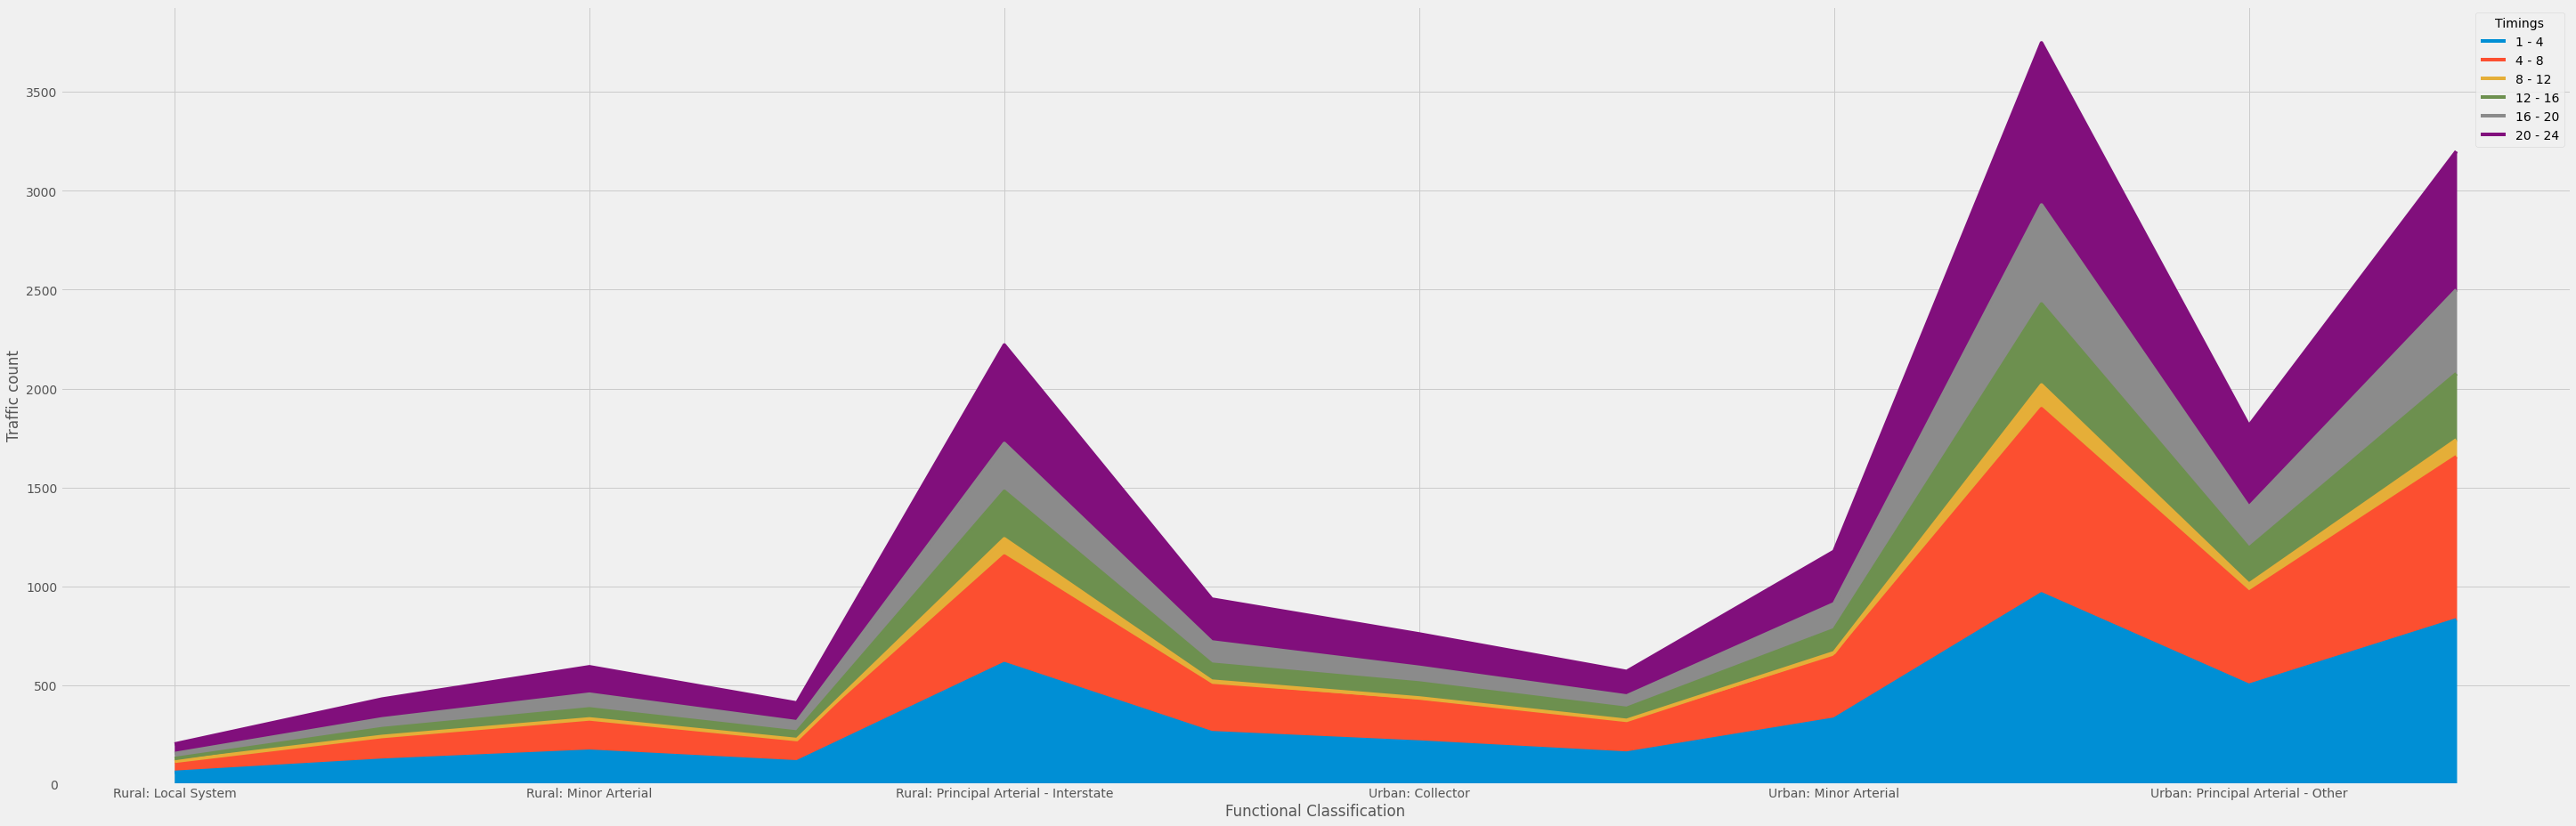

In [30]:
legends=['1 - 4','4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24']
direction_EDA = pd.pivot_table(data=traffic_df, index=['functional_classification_name'], values=timings)
direction_EDA.plot(kind='area', figsize=(45,15), xlabel = 'Functional Classification', ylabel = 'Traffic count')
plt.style.use('fivethirtyeight')
plt.legend(title='Timings', labels=legends)

In [31]:
traffic_df['station_id'].nunique()

5048

In this we are trying to convert station_id into the count of each station_id
since station_id is unique and we have **5048 unique station ID's** we had to perform this step so as to convert it into a feature.

In [32]:
# def integers(x):
#     ref = dict(traffic_df['station_id'].value_counts())
#     if ref.get(x):
#         return ref[x]

# traffic_df['station_id'] = traffic_df['station_id'].apply(integers)



station_id_element_count = dict(traffic_df['station_id'].value_counts())
traffic_df['station_id'] = traffic_df['station_id'].map(station_id_element_count.get)

We can now see in the below density graph that the station Id has been converted into the feature and can contribute in the accuracy of the dataset.

<AxesSubplot:xlabel='station_id', ylabel='Density'>

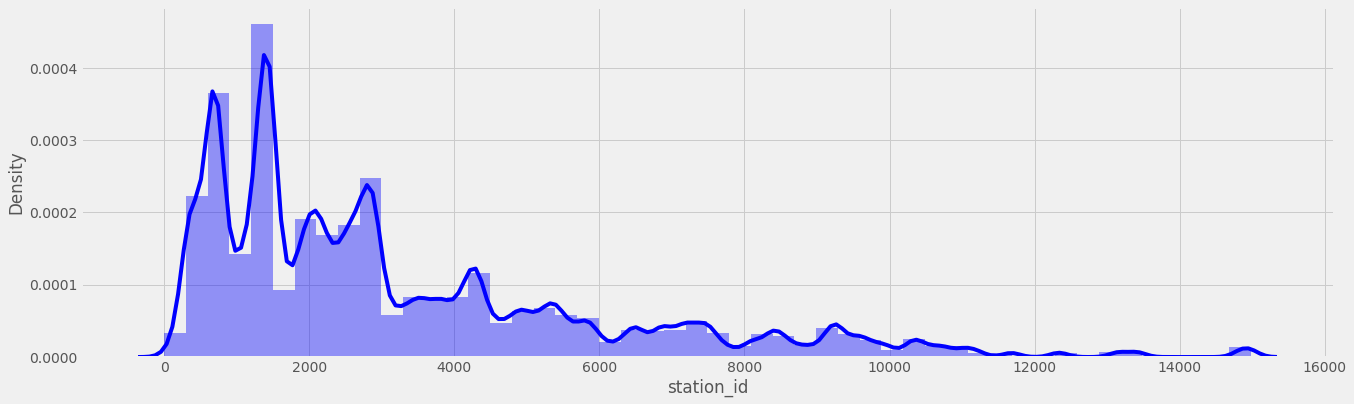

In [33]:
plt.figure(figsize=(20,6))
plt.figure(1)
sns.distplot(traffic_df['station_id'],color='blue')

In the below Code cell we have performed **One Hot Encoding** on the columns **direction_of_travel_name and functional_classification** so that we can convert their unique values into the feature and they can contribute to our final model.

In [34]:
# It is clear that '5U', '6R', '7U', '7R' functional_classification are very much less in number and therefore we can merge them all under one field.
# In the functional_classification column we can see they are categorical ones, so we make new feature out of them.

traffic_df['functional_classification'] = traffic_df['functional_classification'].replace(['5U', '6R', '7U', '7R'], 'other_functional_classifications')
traffic_df['functional_classification_name'] = traffic_df['functional_classification_name'].replace(['Urban: Collector', 
                                                                                                     'Rural: Minor Collector', 
                                                                                                     'Urban: Local System', 
                                                                                                     'Rural: Local System'], 'other_functional_classification_name')

functional_classification_dummy = pd.get_dummies(traffic_df['functional_classification'])

traffic_df = pd.concat([traffic_df, functional_classification_dummy], axis=1)


# In the direction_of_travel_name column we can see they are categorical ones, so we make new feature out of them.

direction_of_travel_name_dummy = pd.get_dummies(traffic_df['direction_of_travel_name'])

traffic_df = pd.concat([traffic_df, direction_of_travel_name_dummy], axis=1)

traffic_df.head()

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,...,East,North,Northeast,Northeast-Southwest,Northwest,South,Southeast,Southeast-Northwest,Southwest,West
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,...,0,1,0,0,0,0,0,0,0,0
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,...,0,0,0,0,0,0,0,0,0,1
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,...,0,0,0,0,0,1,0,0,0,0
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,...,1,0,0,0,0,0,0,0,0,0
6,2015-09-10,10,5,3,East,19,3U,Urban: Principal Arterial - Other,2,9,...,1,0,0,0,0,0,0,0,0,0


We can further Solidify our above mentioned proof that the **maximum amount of traffic occurs in the Direction of Northeast-Southwest** and in time range of 13 to 16 and 17 to 20.

**More Proof for Pattern 2**

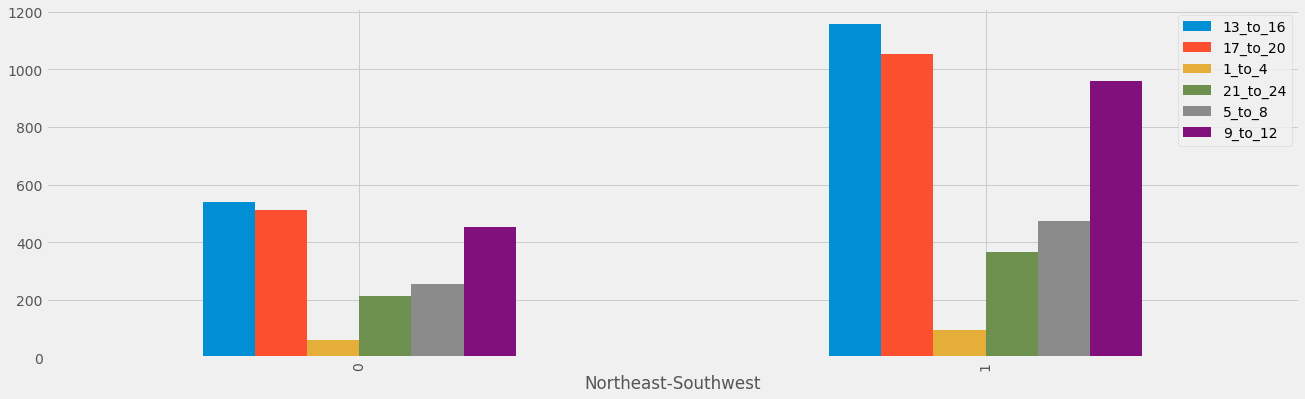

In [35]:
direc = ['North', 'South', 'East', 'West', 'Northeast-Southwest', 'Southeast', 'Northwest', 'Northeast', 'Southeast-Northwest', 'Southwest']
time_rural = pd.pivot_table(traffic_df, index=['Northeast-Southwest'], values =timings)
plt.style.use('fivethirtyeight')
time_rural.plot(kind='bar', figsize=(20, 6));

With the below mentioned Area graph between **Station ID and Lane of Travel** We can conclude that:

- The Reason for Maximum Traffic on the Lane number 7 and Lane number 8 was because **There are more number of stationed located on that path** and because of that people Travel more across those lanes.

**More Proof for Pattern 3**

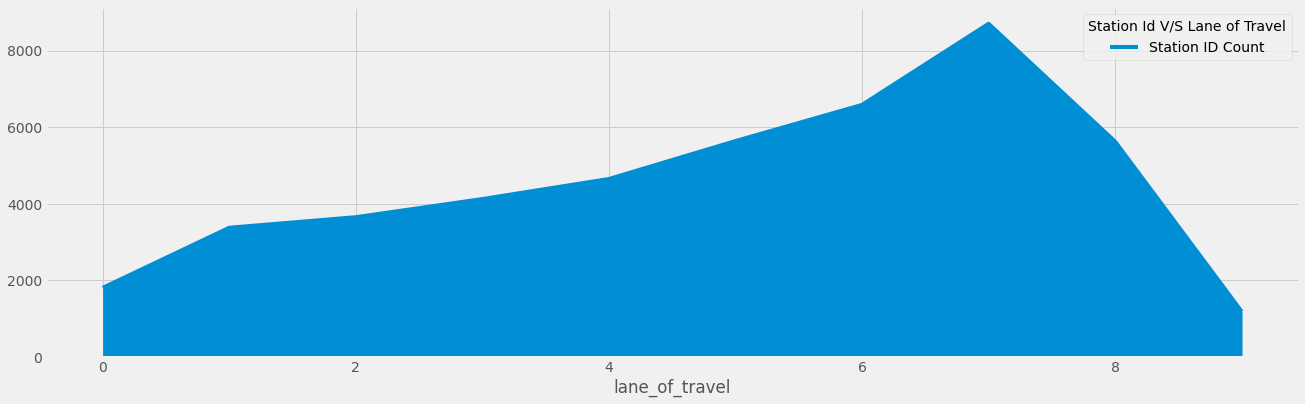

In [36]:
timings=['1_to_4','5_to_8', '9_to_12', '13_to_16', '17_to_20', '21_to_24']
lane_station = pd.pivot_table(traffic_df, index=['lane_of_travel'], values =['station_id'])
plt.style.use('fivethirtyeight')
lane_station.plot(kind='area', figsize=(20, 6));

plt.legend(title='Station Id V/S Lane of Travel', labels=['Station ID Count'])

## **Pattern 5**

From the below mentioned Bar Chart between **Functional Classification and Lane numbers** we can Conclude that:

- Most number of people from **Rural Areas travel mostly on Outer Lanes** (i.e. 5, 6, 7, 8, 9) instead of main Lanes. Infact we can clearly see that There are almost negligible people from Urban Areas travelling in outer lanes except of lane 8 as there as most number of stationes situated in that lane.

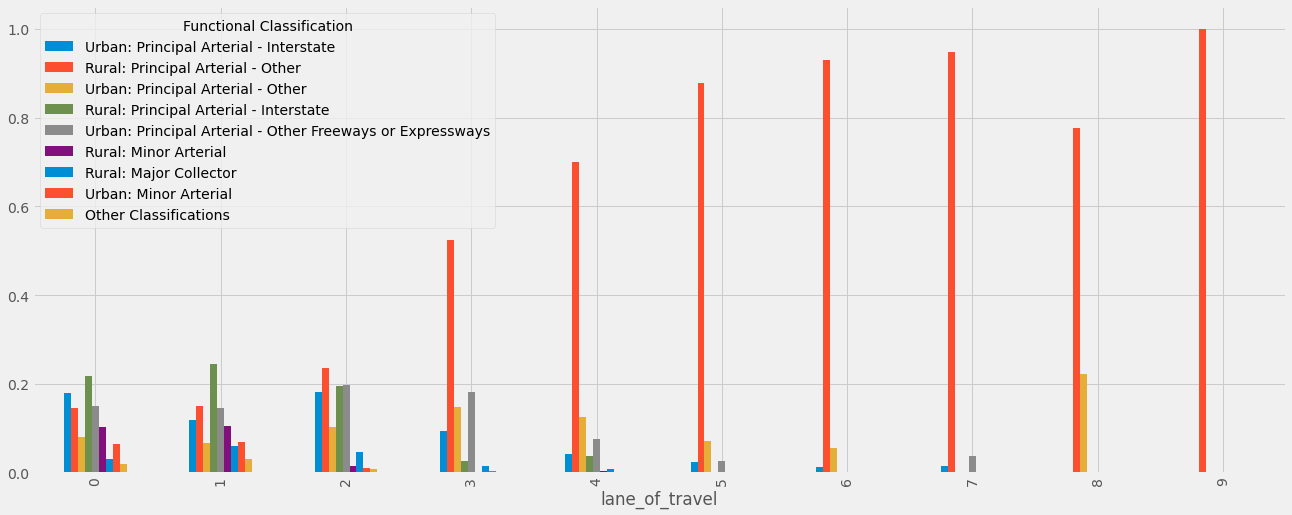

In [37]:
funtional_class = ['1U', '3R', '3U', '1R', '2U', '4R', '5R', '4U', 'other_functional_classifications']
lane_functional = pd.pivot_table(traffic_df, index=['lane_of_travel'], values =funtional_class)
plt.style.use('fivethirtyeight')
lane_functional.plot(kind='bar', figsize=(20, 8));
legends=['Urban: Principal Arterial - Interstate', 'Rural: Principal Arterial - Other', 'Urban: Principal Arterial - Other',
         'Rural: Principal Arterial - Interstate', 'Urban: Principal Arterial - Other Freeways or Expressways', 
         'Rural: Minor Arterial', 'Rural: Major Collector', 'Urban: Minor Arterial', 'Other Classifications']
plt.legend(title='Functional Classification', labels=legends)

We can further solidify our above mentioned argument that **Most amount traffic occurs in Urban: Principal Arterial - Interstate Area in hours 13 to 16 and 17 to 20 i.e. in Evening time mostly**.

**More Proof for Pattern 5**

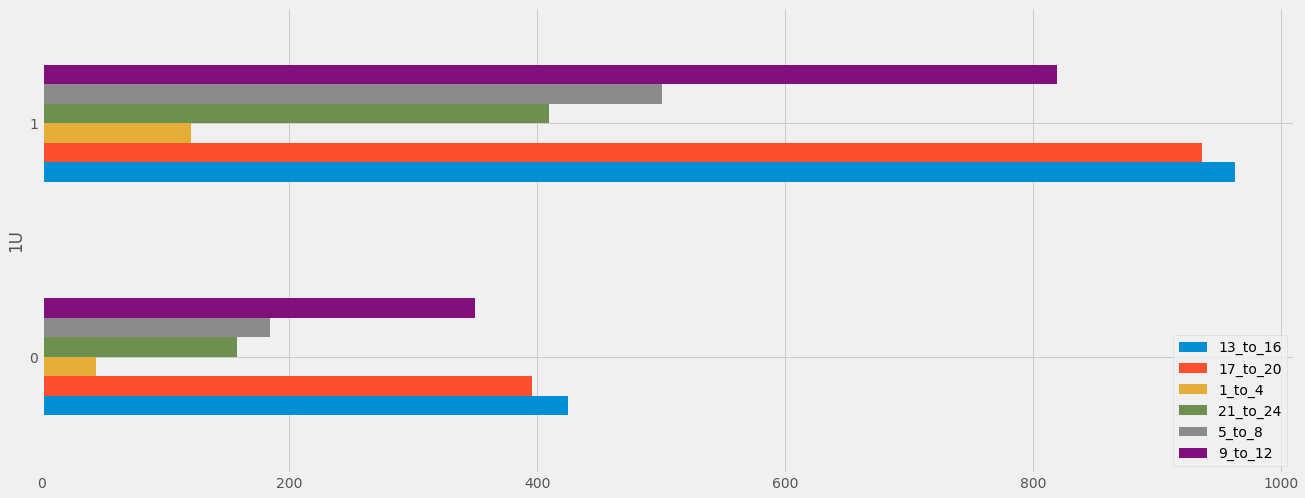

In [38]:
time_rural = pd.pivot_table(traffic_df, index=['1U'], values =timings)
plt.style.use('fivethirtyeight')
time_rural.plot(kind='barh', figsize=(20, 8));

In [39]:
traffic_df.head()

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,...,East,North,Northeast,Northeast-Southwest,Northwest,South,Southeast,Southeast-Northwest,Southwest,West
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,...,0,1,0,0,0,0,0,0,0,0
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,...,0,0,0,0,0,0,0,0,0,1
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,...,0,0,0,0,0,1,0,0,0,0
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,...,1,0,0,0,0,0,0,0,0,0
6,2015-09-10,10,5,3,East,19,3U,Urban: Principal Arterial - Other,2,9,...,1,0,0,0,0,0,0,0,0,0


In [40]:
traffic_df.describe()

,day_of_data,day_of_week,direction_of_travel,fips_state_code,lane_of_travel,month_of_data,station_id,1_to_4,5_to_8,9_to_12,...,East,North,Northeast,Northeast-Southwest,Northwest,South,Southeast,Southeast-Northwest,Southwest,West
count,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,...,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06,6.901954e+06
mean,1.572624e+01,4.012449e+00,3.885063e+00,2.985262e+01,1.335427e+00,6.518998e+00,3.242214e+03,6.073193e+01,2.552298e+02,4.552350e+02,...,2.048695e-01,2.817621e-01,3.734305e-03,7.690286e-03,5.575957e-03,2.799525e-01,5.827190e-03,3.727640e-03,3.690984e-03,2.031696e-01
std,8.770013e+00,2.000232e+00,2.281844e+00,1.657622e+01,1.071629e+00,3.456660e+00,2.796729e+03,8.323963e+01,3.154451e+02,4.602179e+02,...,4.036063e-01,4.498580e-01,6.099476e-02,8.735643e-02,7.446386e-02,4.489756e-01,7.611330e-02,6.094051e-02,6.064125e-02,4.023577e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,4.000000e+00,1.300000e+03,9.000000e+00,4.700000e+01,1.282500e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.600000e+01,4.000000e+00,5.000000e+00,3.000000e+01,1.000000e+00,7.000000e+00,2.367000e+03,2.700000e+01,1.355000e+02,3.105000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.300000e+01,6.000000e+00,5.000000e+00,4.400000e+01,2.000000e+00,1.000000e+01,4.355000e+03,7.975000e+01,3.357500e+02,6.277500e+02,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.100000e+01,7.000000e+00,9.000000e+00,5.600000e+01,9.000000e+00,1.200000e+01,1.497900e+04,7.455000e+02,2.299750e+03,3.270500e+03,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


#### **EDA - STATION DATA**

In [8]:
traffic_station_df.head()

,algorithm_of_vehicle_classification,algorithm_of_vehicle_classification_name,calibration_of_weighing_system,calibration_of_weighing_system_name,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,direction_of_travel,direction_of_travel_name,fips_county_code,...,sample_type_for_vehicle_classification_name,second_type_of_sensor,shrp_site_identification,station_id,station_location,type_of_sensor,type_of_sensor_name,year_of_data,year_station_discontinued,year_station_established
0,NaN,NaN,NaN,NaN,13,3,091,7,West,59,...,Station not used for Heavy Vehicle Travel Info...,N,NaN,129130,LAKEVIEW AVENUE ORA91R10.091,L,Inductance loop,15,0,97
1,NaN,NaN,NaN,NaN,13,3,099,5,South,77,...,Station not used for Heavy Vehicle Travel Info...,N,NaN,100190,LITTLE JOHN CREEK SJ9912.526,L,Inductance loop,15,0,97
2,G,Axle spacing with Scheme F modified,NaN,NaN,15,1,005,1,North,93,...,Station used for Heavy Vehicle Travel Informat...,N,NaN,022940,EDGEWOOD SIS5R22.999,P,Piezoelectric,15,0,69
3,D,Vehicle length classification,M,Moving average of the steering axle of 3S2s,13,0,NaN,5,South,35,...,Station not used for Heavy Vehicle Travel Info...,NaN,NaN,000302,I 15 12900 South M.P. 290.6,X,Radio wave,15,0,11
4,G,Axle spacing with Scheme F modified,0,NaN,14,1,000000,7,West,27,...,Station not used for Heavy Vehicle Travel Info...,NaN,NaN,W01136,E. of Franklin Rd Underpass,L,Inductance loop,15,0,95


In [9]:
print('calibration of weighing system:'.upper())
print(dict(traffic_station_df['calibration_of_weighing_system'].value_counts()), end = '\n\n')
print('calibration of weighing system name:'.upper())
print(dict(traffic_station_df['calibration_of_weighing_system_name'].value_counts()), end = '\n\n')

print('algorithm_of_vehicle_classification:'.upper())
print(dict(traffic_station_df['algorithm_of_vehicle_classification'].value_counts()), end = '\n\n')
print('algorithm_of_vehicle_classification_name:'.upper())
print(dict(traffic_station_df['algorithm_of_vehicle_classification_name'].value_counts()), end = '\n\n')

CALIBRATION OF WEIGHING SYSTEM:
{'T': 1744, 'C': 1683, '0': 1466, 'M': 1347, 'Z': 799, 'U': 546, 'A': 439, 'D': 108, 'P': 10, 'B': 9, '2': 8, 'S': 6}

CALIBRATION OF WEIGHING SYSTEM NAME:
{'Test trucks only': 1744, 'Combination of test trucks and trucks from the traffic stream (but not ASTM E1318)': 1683, 'Moving average of the steering axle of 3S2s': 1347, 'Other method': 799, 'Uncalibrated': 546, 'ASTM Standard E1318': 439, 'Other sample of trucks from the traffic stream': 108, 'Subset of ASTM Standard E1318': 9, 'Static calibration': 6}

ALGORITHM_OF_VEHICLE_CLASSIFICATION:
{'F': 7100, 'G': 5155, 'D': 2267, '0': 1231, 'L': 1082, 'K': 548, 'Z': 465, 'M': 420, 'N': 116, 'H': 98, 'C': 42, 'A': 36, '1': 10, 'E': 6}

ALGORITHM_OF_VEHICLE_CLASSIFICATION_NAME:
{'Axle spacing with Scheme F': 7100, 'Axle spacing with Scheme F modified': 5155, 'Vehicle length classification': 2267, 'Axle spacing and vehicle length algorithm': 1082, 'Axle spacing and weight algorithm': 548, 'Other means not sp

In the below code cell we are performing **One Hot Encoding** to convert many useless columns into features.

In [10]:
# It is clear that 'D', 'P', 'B', '2', 'S' calibration_of_weighing_system are very much less in number and therefore we can merge them all under one field.
# In the calibration_of_weighing_system column we can see they are categorical ones, so we make new feature out of them.

traffic_station_df['calibration_of_weighing_system'] = traffic_station_df['calibration_of_weighing_system'].replace(['D', 'P', 'B', '2', 'S'], 'other_calibration_of_weighing_system')

calibration_of_weighing_system_dummy = pd.get_dummies(traffic_station_df['calibration_of_weighing_system'])

traffic_station_df = pd.concat([traffic_station_df, calibration_of_weighing_system_dummy], axis=1)


# It is clear that 'Z', 'M', 'N', 'H', 'C', 'A', '1', 'E' algorithm_of_vehicle_classification are very much less in number and therefore we can merge them all under one field.
# In the algorithm_of_vehicle_classification column we can see they are categorical ones, so we make new feature out of them.

traffic_station_df['algorithm_of_vehicle_classification'] = traffic_station_df['algorithm_of_vehicle_classification'].replace(['Z', 'M', 'N', 'H', 'C', 'A', '1', 'E'], 'other_algorithm_of_vehicle_classification')
traffic_station_df['algorithm_of_vehicle_classification'] = traffic_station_df['algorithm_of_vehicle_classification'].replace(['0'], 'A_0')

algorithm_of_vehicle_classification_dummy = pd.get_dummies(traffic_station_df['algorithm_of_vehicle_classification'])

traffic_station_df = pd.concat([traffic_station_df, algorithm_of_vehicle_classification_dummy], axis=1)

# Renaming the very long column name.

traffic_station_df["direction_of_travel_name"].replace({"North-South or Northeast-Southwest combined (ATR stations only)": "Northeast-Southwest", 
                                                "East-West or Southeast-Northwest combined (ATR stations only)": "Southeast-Northwest"}, inplace=True)

# In the direction_of_travel_name column we can see they are categorical ones, so we make new feature out of them.

direction_of_travel_name_dummy1 = pd.get_dummies(traffic_station_df['direction_of_travel_name'])

traffic_station_df = pd.concat([traffic_station_df, direction_of_travel_name_dummy1], axis=1)


# It is clear that '5U', '6R', '7U', '7R' functional_classification are very much less in number and therefore we can merge them all under one field.
# In the functional_classification column we can see they are categorical ones, so we make new feature out of them.

traffic_station_df['functional_classification'] = traffic_station_df['functional_classification'].replace(['5U', '6R', '7U', '7R'], 'other_functional_classifications')
traffic_station_df['functional_classification_name'] = traffic_station_df['functional_classification_name'].replace(['Urban: Collector', 
                                                                                                     'Rural: Minor Collector', 
                                                                                                     'Urban: Local System', 
                                                                                                     'Rural: Local System'], 'other_functional_classification_name')

functional_classification_dummy1 = pd.get_dummies(traffic_station_df['functional_classification'])

traffic_station_df = pd.concat([traffic_station_df, functional_classification_dummy1], axis=1)


# In the lane_of_travel_name column we can see they are categorical ones, so we make new feature out of them.

traffic_station_df['lane_of_travel_name'] = traffic_station_df['lane_of_travel_name'].replace(['Outside (rightmost) lane'], 'Outside_rightmost_lane')
traffic_station_df['lane_of_travel_name'] = traffic_station_df['lane_of_travel_name'].replace(['Data with lanes combined'], 'Data_with_lanes_combined')
traffic_station_df['lane_of_travel_name'] = traffic_station_df['lane_of_travel_name'].replace(['Other lanes'], 'Other_lanes')

lane_of_travel_name_dummy = pd.get_dummies(traffic_station_df['lane_of_travel_name'])

traffic_station_df = pd.concat([traffic_station_df, lane_of_travel_name_dummy], axis=1)


# In the method_of_traffic_volume_counting_name column we can see they are categorical ones, so we make new feature out of them.


traffic_station_df.replace({'method_of_traffic_volume_counting_name' : { 'Permanent automatic traffic recorder (ATR)' : 'TVC_Automatic', 
                                                               'Portable traffic recording device' : 'TVC_Portable',
                                                                'Human observation (manual)': 'TVC_Manual'}}, inplace=True)

method_of_traffic_volume_counting_name_dummy = pd.get_dummies(traffic_station_df['method_of_traffic_volume_counting_name'])

traffic_station_df = pd.concat([traffic_station_df, method_of_traffic_volume_counting_name_dummy], axis=1)

traffic_station_df.head()

,algorithm_of_vehicle_classification,algorithm_of_vehicle_classification_name,calibration_of_weighing_system,calibration_of_weighing_system_name,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,direction_of_travel,direction_of_travel_name,fips_county_code,...,4R,4U,5R,other_functional_classifications,Data_with_lanes_combined,Other_lanes,Outside_rightmost_lane,TVC_Automatic,TVC_Manual,TVC_Portable
0,NaN,NaN,NaN,NaN,13,3,091,7,West,59,...,0,0,0,0,0,1,0,1,0,0
1,NaN,NaN,NaN,NaN,13,3,099,5,South,77,...,0,0,0,0,0,0,1,1,0,0
2,G,Axle spacing with Scheme F modified,NaN,NaN,15,1,005,1,North,93,...,0,0,0,0,0,1,0,1,0,0
3,D,Vehicle length classification,M,Moving average of the steering axle of 3S2s,13,0,NaN,5,South,35,...,0,0,0,0,0,0,1,1,0,0
4,G,Axle spacing with Scheme F modified,0,NaN,14,1,000000,7,West,27,...,0,0,0,0,0,1,0,0,0,1


In the below code cell we are converting the columns which contains only 2 values into vinary values on 1 and 0 so that they can be machine readable and can be used as a feature.

In [11]:
traffic_station_df.replace({'sample_type_for_traffic_volume_name' : {'Station used for Traffic Volume Trends': 1, 
                                                                     'Station not used for Traffic Volume Trends': 0}}, inplace=True)

traffic_station_df.replace({'sample_type_for_vehicle_classification_name' : {'Station used for Heavy Vehicle Travel Information System': 1, 
                                                                             'Station not used for Heavy Vehicle Travel Information System': 0}}, inplace=True)

traffic_station_df.replace({'method_of_data_retrieval_name' : { 'Automated (telemetry)' : 1, 'Not automated (manual)' : 0}}, inplace=True)

traffic_station_df.replace({'hpms_sample_type' : { 'N' : 1, 'Y' : 0}}, inplace=True)

traffic_station_df.replace({'national_highway_system' : { 'N' : 0, 'Y' : 1}}, inplace=True)

Here we are converting all the columns which contains many unique values into the counts of each value so that they all can be used as the feature and contribute into our model accuracy.

In [12]:
year_station_established_count = dict(traffic_station_df['year_station_established'].value_counts())
traffic_station_df['year_station_established'] = traffic_station_df['year_station_established'].map(year_station_established_count.get)

year_station_discontinued_count = dict(traffic_station_df['year_station_discontinued'].value_counts())
traffic_station_df['year_station_discontinued'] = traffic_station_df['year_station_discontinued'].map(year_station_discontinued_count.get)

station_id_element_count1 = dict(traffic_station_df['station_id'].value_counts())
traffic_station_df['station_id'] = traffic_station_df['station_id'].map(station_id_element_count1.get)

previous_station_id_count = dict(traffic_station_df['previous_station_id'].value_counts())
traffic_station_df['previous_station_id'] = traffic_station_df['previous_station_id'].map(previous_station_id_count.get)

posted_signed_route_number_count = dict(traffic_station_df['posted_signed_route_number'].value_counts())
traffic_station_df['posted_signed_route_number'] = traffic_station_df['posted_signed_route_number'].map(posted_signed_route_number_count.get)

Here we are dropping all the useless column and the columns we have already converted into the features.

In [13]:
traffic_station_df.drop(['calibration_of_weighing_system', 'calibration_of_weighing_system_name', 
                         'algorithm_of_vehicle_classification', 'algorithm_of_vehicle_classification_name',
                        'direction_of_travel_name', 'functional_classification','functional_classification_name', 'lane_of_travel_name',
                        'method_of_traffic_volume_counting_name', 'year_of_data', 'station_location', 'method_of_truck_weighing_name',
                        'record_type', 'sample_type_for_traffic_volume', 'sample_type_for_truck_weight_name',
                        'sample_type_for_truck_weight', 'sample_type_for_vehicle_classification', 'type_of_sensor_name',
                        'type_of_sensor', 'second_type_of_sensor', 'primary_purpose', 'primary_purpose_name', 
                        'method_of_vehicle_classification_name'], axis = 1, inplace=True)
traffic_station_df.reset_index(inplace=True, drop=True)

### **Training and Testing of Model**

In [15]:
# Removing the unnecesary columns and the columns with non numerical values.
traffic_df_m = traffic_df.drop(['date', 'direction_of_travel_name', 'functional_classification_name', 'functional_classification', 'fips_state_code'], axis = 1)

In [42]:
traffic_df_m = traffic_df_m.drop(['station_id'], axis = 1)

In [57]:
traffic_df_m = traffic_df_m.drop(['restrictions'], axis=1)

In [58]:
traffic_df_m.reset_index(inplace=True, drop=True)
traffic_df_m.head()

,day_of_data,day_of_week,direction_of_travel,lane_of_travel,month_of_data,record_type,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,...,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
0,7,3,1,1,4,3,4,3,2,4,...,89,122,124,110,69,73,28,12,6,15
1,26,7,7,2,9,3,381,252,218,194,...,1617,1669,1308,1068,928,885,798,650,613,15
2,16,3,3,0,6,3,585,408,328,364,...,4244,4405,4609,4361,3272,2243,2050,1453,892,15
3,26,1,5,1,4,3,105,73,68,66,...,1011,959,851,708,559,457,297,207,110,15
4,23,7,3,0,5,3,6,4,2,3,...,83,61,55,35,29,21,23,9,7,15


Splitting our data into training and testing data.
Our target value of the model will be the lane of travel.

In [35]:
## traffic_df_mm = pd.get_dummies(traffic_df_m['station_id'])

In [59]:
# Setting up our X and Y axis i.e. input(X axis) and output(Y axis) i.e. target value.
# Splitting out training data into new Train data and Validation data.

y = traffic_df_m['lane_of_travel']
X_train = traffic_df_m.drop(['lane_of_travel'], axis = 1)
Xtrain ,Xtest, ytrain, ytest = train_test_split(X_train, y, test_size = 0.2, random_state=0)

In [18]:
# Defining Lists to Store in the Results and Names of Algorithms
MSE_Score = []
R2_Score = []
Algorithm = []

In [53]:
# Xtrain.drop(['station_id'], axis=)

### Decision Tree

In [25]:
# Xtrain[0:10]

In [21]:
from sklearn import tree

In [54]:
# Xtrain.info()
# Xtrain.loc[Xtrain.station_id =='LC0200', ]
Xtrain.head()

,day_of_data,day_of_week,direction_of_travel,month_of_data,record_type,restrictions,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,...,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
7052181,13,6,5,2,3,NaN,438,317,210,202,...,1790,1858,1724,1611,1416,1192,1147,960,826,15
1046231,7,7,1,3,3,NaN,172,76,85,64,...,738,702,659,601,548,440,356,324,233,15
5029291,9,5,1,7,3,NaN,294,258,205,233,...,1112,1164,1189,1018,983,807,693,556,429,15
4964924,8,7,3,8,3,NaN,43,26,24,10,...,173,171,173,190,171,148,91,81,61,15
3023772,3,5,7,12,3,NaN,28,27,23,26,...,359,338,338,224,166,140,93,57,53,15


In [60]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xtrain, ytrain)

In [61]:
# Predicting the output using our trained model
Output = clf.predict(Xtest)

In [153]:
Output
accuracy_train = round(clf.score(Xtest, ytest)*100,2)

print("Decision Tree Accuracy Score : ", round(accuracy_train,2),'%')

Decision Tree Accuracy Score :  69.72 %


In [151]:
# mean_squared_error(ytest, Output)

In [118]:
# Output

### CNN model

In [66]:
# !pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=7775be57d3fc93ecb4a39edb216587628c27994890e0fbe7496288625b51fcd4
  Stored in directory: c:\users\solai\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [67]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [87]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


In [128]:
# choose a number of time steps
n_steps = 30
n_features = 1
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [154]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 14, 64)           0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 896)               0         
                                                                 
 dense_18 (Dense)            (None, 50)                44850     
                                                                 
 dense_19 (Dense)            (None, 1)                 51        
                                                                 
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
_________________________________________________

In [129]:
X = Xtrain[0:10000].values.reshape(Xtrain[0:10000].values.shape[0], Xtrain[0:10000].values.shape[1], n_features)
# X

In [130]:
# fit model
model.fit(X, ytrain_t[0:10000], epochs=10, verbose=1)

Epoch 1/10
313/313 [==============================] - 4s 4ms/step - loss: 1.5532e-07 - accuracy: 0.2370
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 1.5532e-07 - accuracy: 0.2370
Epoch 3/10
313/313 [==============================] - 1s 3ms/step - loss: 1.5532e-07 - accuracy: 0.2370
Epoch 4/10
313/313 [==============================] - 1s 3ms/step - loss: 1.5532e-07 - accuracy: 0.2370
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 1.5532e-07 - accuracy: 0.2370
Epoch 6/10
313/313 [==============================] - 1s 3ms/step - loss: 1.5532e-07 - accuracy: 0.2370
Epoch 7/10
313/313 [==============================] - 1s 3ms/step - loss: 1.5532e-07 - accuracy: 0.2370
Epoch 8/10
313/313 [==============================] - 1s 3ms/step - loss: 1.5532e-07 - accuracy: 0.2370
Epoch 9/10
313/313 [==============================] - 1s 3ms/step - loss: 1.5532e-07 - accuracy: 0.2370
Epoch 10/10
313/313 [==============================] - 1s 4ms/st

In [142]:
# demonstrate prediction
# x_input = Xtest[0:1000].values.reshape((1, n_steps, n_features))
X_input = Xtest[0:1000].values.reshape(Xtest[0:1000].values.shape[0], Xtest[0:1000].values.shape[1], n_features)

yhat = model.predict(X_input, verbose=1)

32/32 [==============================] - 0s 2ms/step


In [144]:
yhat.shape
# yhat

(1000, 1)

In [149]:
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
# mean_squared_error(ytest[0:1000], yhat)
# accuracy_score(ytest[0:1000], yhat)
cnn_score = accuracy_score(ytest[0:1000], np.round(abs(yhat)), normalize=False)*10
# confusion_matrix(ytest[0:1000], yhat)

In [155]:
print("CNN Accuracy Score: ", cnn_score, "%")

CNN Accuracy Score:  80 %
